(1001, 6) (6, 1001)


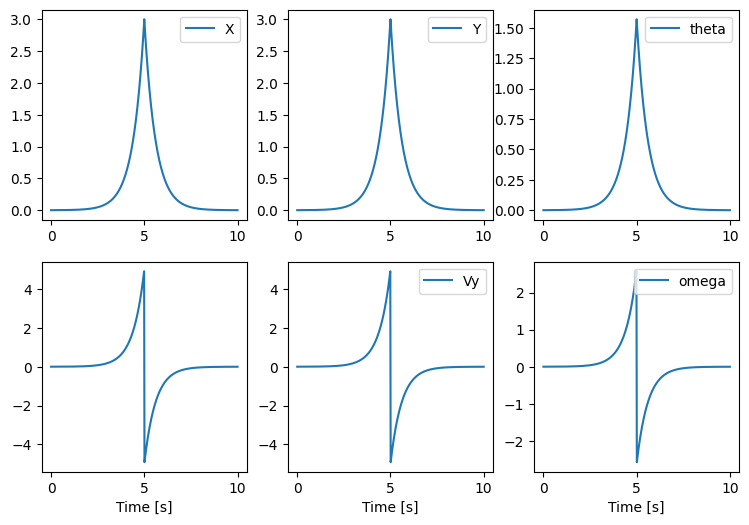

<Figure size 640x480 with 0 Axes>

In [2]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')
import quadrotor as qd
import math
import import_ipynb
import Part2_lqr_stabilization as p2



horizon_length = 1000
N = 1000
u_ = qd.MASS * qd.GRAVITY / 2
z0 = np.array([1,0,0,0,0,0]).reshape([6,])
u0 = u_ * np.ones([2,1])
o = (2*math.pi/10)/6
r = 1
T = 10
middle = 500
tau = 0.6


def generate_place(i):
    t = T/N*i
    return 3*math.e**(-abs(t-5)/tau)
def generateV(i):
    t = T/N*i
    if i<middle:
        return 3/tau*math.e**(-abs(t-5)/tau)
    elif i == middle:
        return 0
    else:
        return -3/tau*(math.e**(-abs(t-5)/tau))
def generate_theta(i):
    t = T/N*i
    return math.pi/2*math.e**(-abs(t-5)/tau)
def generate_omega(i):
    t = T/N*i
    if i<middle:
        return math.pi/2/tau*math.e**(-abs(t-5)/tau)
    elif i == middle:
        return 0
    else:
        return -math.pi/2/tau*math.e**(-abs(t-5)/tau)
    
x_desired = [generate_place(i) for i in range(N+1)]
vx_desired = [generateV(i) for i in range(N+1)]
y_desired = [generate_place(i) for i in range(N+1)]
vy_desired = [generateV(i) for i in range(N+1)]
theta_desried = [generate_theta(i) for i in range(N+1)]
omega_desried = [generate_omega(i) for i in range(N+1)]




state_desired = np.array([x_desired,vx_desired,y_desired,vy_desired,theta_desried,omega_desried])
ref_traj = state_desired.T
z0 = np.zeros_like(state_desired[:,0])
u_init = [(qd.MASS * qd.GRAVITY / 2) * np.ones([2]) for _ in range(horizon_length)]
print(ref_traj.shape,state_desired.shape)



t = [T/N*i for i in range(N+1)]
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state_desired[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state_desired[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state_desired[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state_desired[1,:])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state_desired[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state_desired[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
import solver
try:
    import jax.numpy as np
except ImportError:
    import numpy as np

class iLQR_Track_Controller:
    def __init__(self,R,dt,use_autograd = False):
        self.aux = None
        self.R_ = R
        self.dt_ = dt

        #desired functions for plant dynamics and cost
        self.plant_dyn_ = None
        self.plant_dyn_dx_ = None
        self.plant_dyn_du_ = None

        self.cost_ = None
        self.cost_dx_ = None
        self.cost_du_ = None
        self.cost_dxx_ = None
        self.cost_duu_ = None
        self.cost_dux_ = None

        self.ilqr_ = None

        self.use_autograd=use_autograd
        return

    def build_iLQR_tracking(self,ref_pnts, weight_mats,obj):
        #obj must have next_state,  get_linearization
        self.obj = obj
        #figure out dimension
        self.T_ = len(ref_pnts)# leave the last point alone


        self.ref_array = np.copy(ref_pnts)
        self.weight_array = [mat for mat in weight_mats]
        #clone weight mats if there are not enough weight mats
        for i in range(self.T_ - len(self.weight_array)):
            self.weight_array.append(self.weight_array[-1])


        def tmp_cost_func(x, u, t, aux):
            err = x - self.ref_array[t]
            #autograd does not allow A.dot(B)
            cost = np.dot(np.dot(err, self.weight_array[t]), err) + np.sum(u**2) * self.R_
            return cost

        self.cost_ = tmp_cost_func
        self.ilqr_ = solver.Solver(T=self.T_ - 1, plant_dyn=self.plant_dyn_, cost=self.cost_,
                                   use_autograd=self.use_autograd)
        if not self.use_autograd:
            self.plant_dyn = lambda x, u, t, aux:qd.get_next_state(x,u)
            self.plant_dyn_du_ = lambda x, u, t, aux: p2.get_linearization(x, u)[0]
            self.plant_dyn_dx_ = lambda x, u, t, aux: p2.get_linearization(x, u)[1]
            def tmp_cost_func_dx(x, u, t, aux):
                err = x - self.ref_array[t]
                grad = np.concatenate([2 * err.dot(self.weight_array[t])])
                return grad

            self.cost_dx_ = tmp_cost_func_dx

            self.cost_du_ = lambda x, u, t, aux: 2 * self.R_ * u

            def tmp_cost_func_dxx(x, u, t, aux):
                hessian = np.zeros((qd.NUMBER_STATES,qd.NUMBER_STATES))
                hessian = 2 * self.weight_array[t]
                return hessian

            self.cost_dxx_ = tmp_cost_func_dxx

            self.cost_duu_ = lambda x, u, t, aux: 2 * self.R_ * np.eye(qd.NUMBER_CONTROLS)
            self.cost_dux_ = lambda x, u, t, aux: np.zeros((qd.NUMBER_CONTROLS,qd.NUMBER_STATES))

            # build an iLQR solver based on given functions...
            self.ilqr_.plant_dyn = self.plant_dyn
            self.ilqr_.plant_dyn_dx = self.plant_dyn_dx_
            self.ilqr_.plant_dyn_du = self.plant_dyn_du_
            self.ilqr_.cost_dx = self.cost_dx_
            self.ilqr_.cost_du = self.cost_du_
            self.ilqr_.cost_dxx = self.cost_dxx_
            self.ilqr_.cost_duu = self.cost_duu_
            self.ilqr_.cost_dux = self.cost_dux_
        return

    def synthesize_trajectory(self,x0, u_array=None, n_itrs=50, tol=1e-6, verbose=True):
        if self.ilqr_ is None:
            print('No iLQR solver has been prepared.')
            return None
        #initialization doesn't matter as global optimality can be guaranteed?
        if u_array is None:
            u_init = [np.zeros(qd.NUMBER_CONTROLS) for i in range(self.T_-1)]
        else:
            u_init = u_array
        x_init = np.zeros(qd.NUMBER_STATES)
        x_init[:len(x0)] = x0

        # res = self.lqr_.ilqr_iterate(x_init, u_init, n_itrs=n_itrs, tol=tol, verbose=verbose)
        res_dict = self.ilqr_.LQR_solve(x_init, u_init)
        x_star = res_dict['x_array_star']
        Ks = res_dict['K_array_opt']
        ks = res_dict['k_array_opt']
        x_array_new, u_array_new = self.apply_control(x_star, u_init, ks, Ks,alpha=1)
        return x_array_new[:, 0:qd.NUMBER_CONTROLS]

    def get_rule(self,x0, u_array=None, n_itrs=50, tol=1e-6, verbose=True):
        if self.ilqr_ is None:
            print('No iLQR solver has been prepared.')
            return None
        #initialization doesn't matter as global optimality can be guaranteed?
        if u_array is None:
            u_init = [np.zeros(qd.NUMBER_CONTROLS) for i in range(self.T_-1)]
        else:
            u_init = u_array
        x_init = np.zeros(qd.NUMBER_STATES)
        x_init[:len(x0)] = x0

        # res = self.lqr_.ilqr_iterate(x_init, u_init, n_itrs=n_itrs, tol=tol, verbose=verbose)
        res_dict = self.ilqr_.iLQR_iteration(x_init, u_init,n_itrs)
        # x_star = res_dict['x_array_star']
        # Ks = res_dict['K_array_opt']
        # ks = res_dict['k_array_opt']
        # xs = res_dict['x_array_opt']
        # us = res_dict['u_array_opt']
        return res_dict

    def controller(self,u,x,k_array,K_array):
        pass

    def apply_control(self, x_array, u_array, k_array, K_array,alpha=1) :
        x_new_array = [None] * len(x_array)
        u_new_array = [None] * len(u_array)
        x_new_array[0] = x_array[0]
        for t in range(self.T_ -1 ):
            u_new_array[t] = u_array[t] + alpha * (k_array[t] + K_array[t].dot(x_new_array[t]-x_array[t]))
            x_new_array[t+1] = qd.get_next_state(x_new_array[t], u_new_array[t])
        return np.array(x_new_array), np.array(u_new_array)
        

In [3]:
weight_mats = [100*np.diag([60,5,40,5,50,1])*(math.e**(-abs(i-middle)/100)) for  i in range(len(ref_traj))]


ilqr_traj_ctrl = iLQR_Track_Controller(R=.01, dt=0.01)
ilqr_traj_ctrl.build_iLQR_tracking(ref_traj, weight_mats, p2)
x0 = ref_traj[0]
res = ilqr_traj_ctrl.get_rule(x0, u_init,n_itrs = 200, tol = 1)
x_array = res["x_array_opt"]
u_array = res["u_array_opt"]
k_array = res["k_array_opt"]
K_array = res["K_array_opt"]
def ilqr_controller(state,i):
    ut = K_array[i].dot(state-x_array[i]) + k_array[i] + u_array[i]
    return ut.T
t, state, u = qd.simulate(z0,ilqr_controller, horizon_length, disturbance = False)

In [ ]:
# we can plot the results
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.plot(t, state_desired[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.plot(t, state_desired[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.plot(t, state_desired[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.plot(t, state_desired[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.plot(t, state_desired[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.plot(t, state_desired[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')
qd.animate_robot(state,u)